## 12.19.2018 Meelad Amouzgar
Support Vector Machines: Supervised learning models for classification and regression analysis of labeled data to predict diabetes

In [2]:
import numpy as np
import pandas as pd      # built on top of numpy
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns    # built on top of matplotlib
import scipy as sp
from sklearn import datasets, svm
from pandas.api.types import CategoricalDtype # enables specifying categorical agetype below

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import Imputer, MinMaxScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
#import sklearn.metrics as skm

from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [3]:
df = pd.read_csv("diabetes2.csv", delimiter = ',') 

In [5]:
print(df.head(5))  # include headers and first 5 rows
df.describe() # Looks like the summary() function in R
# plas is plasma glucose level
# pres is blood pressure

   preg  plas  pres  skin  insu  mass   pedi  age  class
0     6   148    72    35     0  33.6  0.627   50      1
1     1    85    66    29     0  26.6  0.351   31      0
2     8   183    64     0     0  23.3  0.672   32      1
3     1    89    66    23    94  28.1  0.167   21      0
4     0   137    40    35   168  43.1  2.288   33      1


,preg,plas,pres,skin,insu,mass,pedi,age,class
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [6]:
df.info() # provides information on variable type

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
preg     768 non-null int64
plas     768 non-null int64
pres     768 non-null int64
skin     768 non-null int64
insu     768 non-null int64
mass     768 non-null float64
pedi     768 non-null float64
age      768 non-null int64
class    768 non-null int64
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [7]:
df2 = df.copy(deep=True)
## Cleaning the dataset
# use replace as pure function:
df2['skin'] = df['skin'].replace(0,np.NaN)
df2['plas'] = df['plas'].replace(0,np.NaN)
df2['pres'] = df['pres'].replace(0,np.NaN)
df2['insu'] = df['insu'].replace(0,np.NaN)
df2['mass'] = df['mass'].replace(0,np.NaN)

# print df2.apply(np.nanmedian, axis = 0)
# print df2.info()
df2.describe() # Provides summary statistics on the data

,preg,plas,pres,skin,insu,mass,pedi,age,class
count,768.000000,763.000000,733.000000,541.000000,394.000000,757.000000,768.000000,768.000000,768.000000
mean,3.845052,121.686763,72.405184,29.153420,155.548223,32.457464,0.471876,33.240885,0.348958
std,3.369578,30.535641,12.382158,10.476982,118.775855,6.924988,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,64.000000,22.000000,76.250000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,29.000000,125.000000,32.300000,0.372500,29.000000,0.000000
75%,6.000000,141.000000,80.000000,36.000000,190.000000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


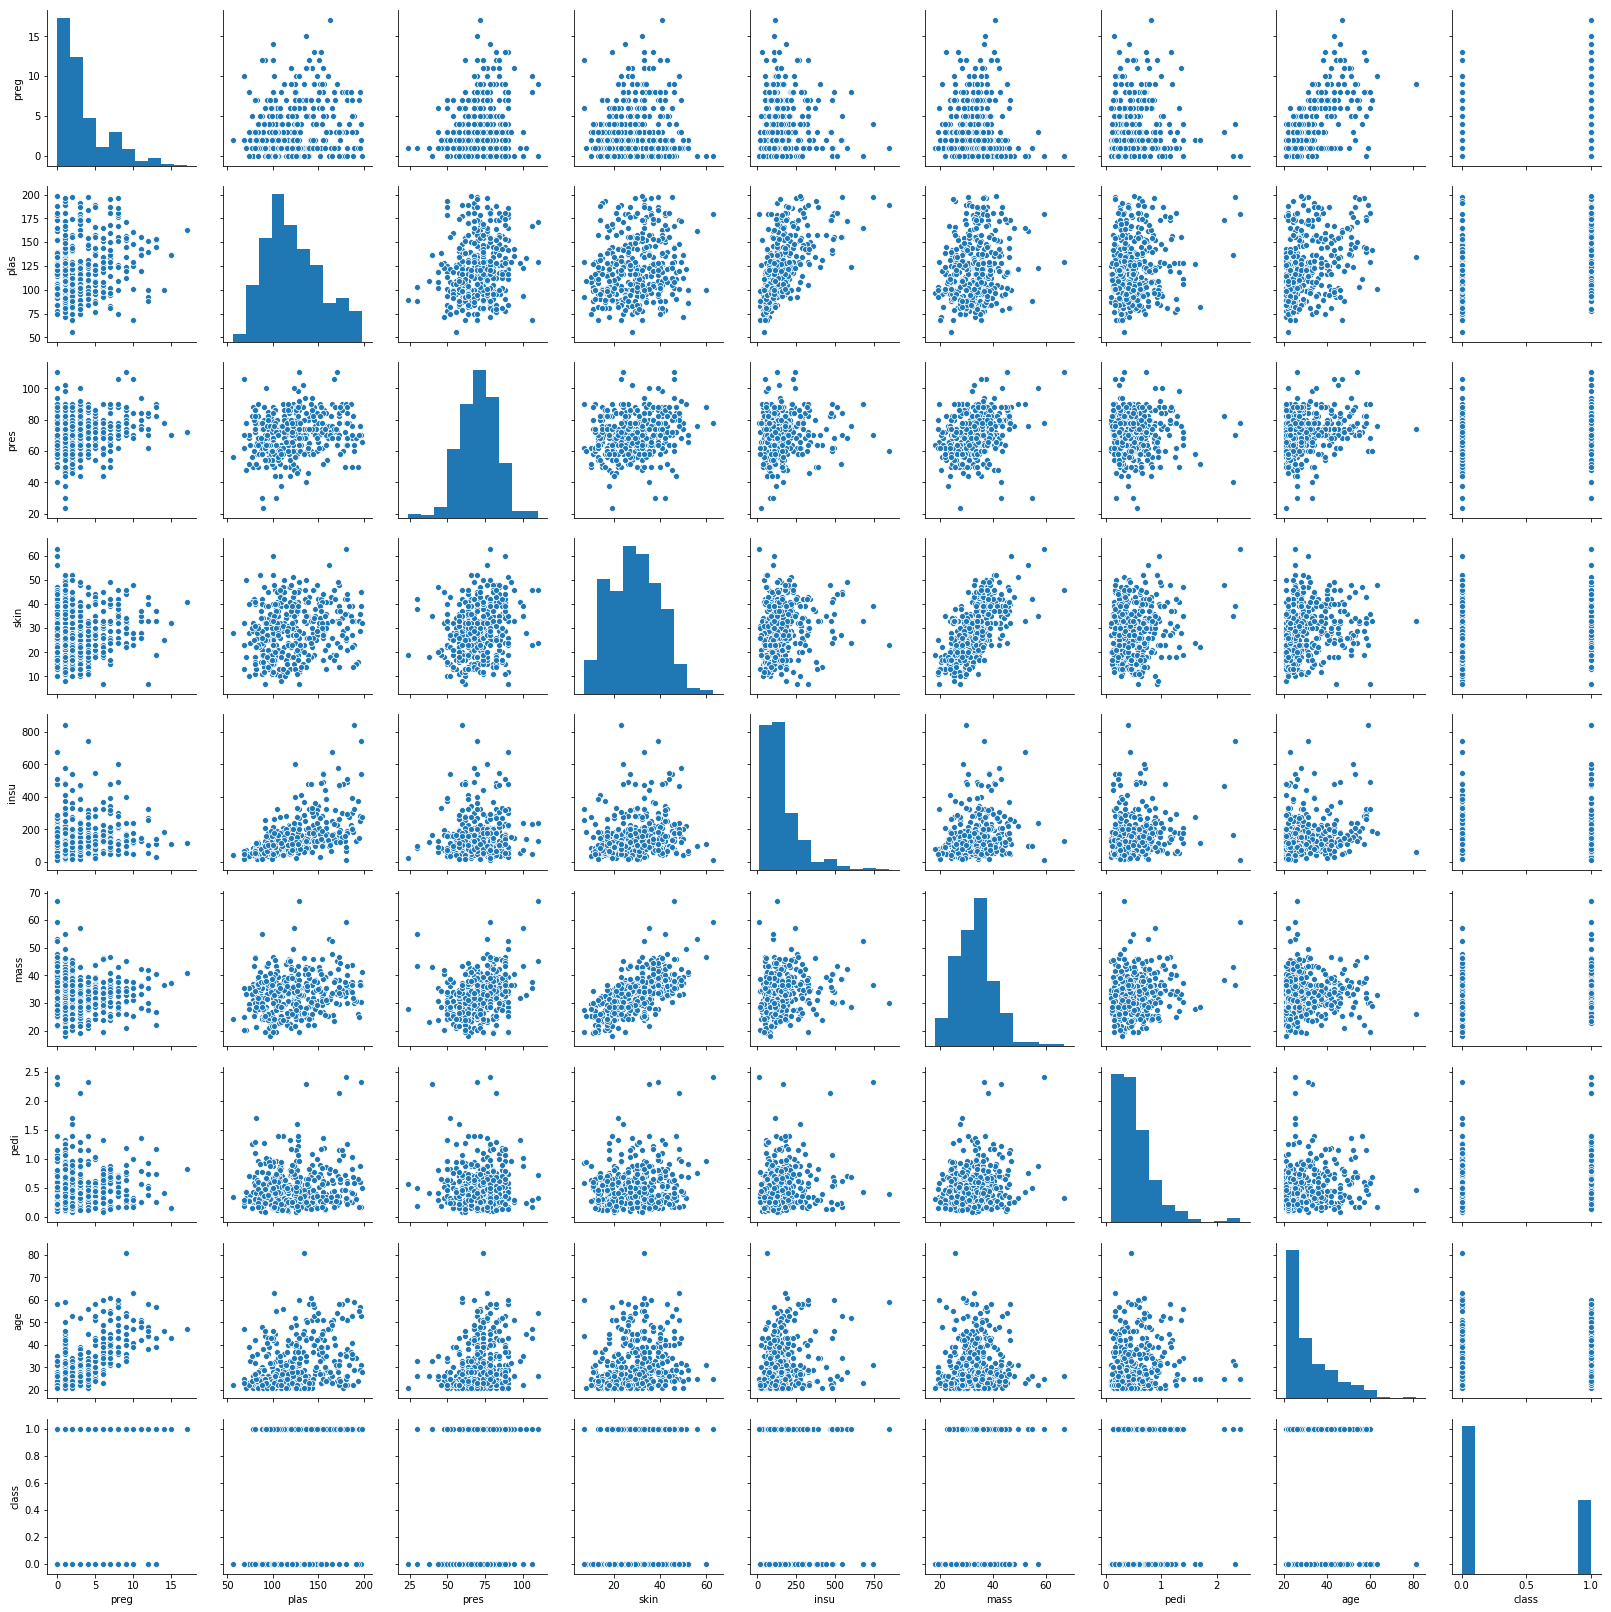

In [8]:
plot_df = df2.dropna()
sns.pairplot(plot_df)
# plots the pairwise comparisons of the data
## mass and skin appear correlated
## preg and age appear correlated
## pres and plas appear correlated

In [9]:
correlations = sp.stats.spearmanr(plot_df, axis = 0)
correlations #left to Right: preg,plas, pres, skin, insu,mass,pedi,age,class
# Provides  spearman statistical analyses tests (correlations) for each variable in the table.

SpearmanrResult(correlation=array([[ 1.        ,  0.19048148,  0.15241404,  0.05475868,  0.12315371,
        -0.06555144,  0.01171335,  0.63365655,  0.20023445],
       [ 0.19048148,  1.        ,  0.23660931,  0.21583824,  0.65895822,
         0.19907115,  0.08934581,  0.3503047 ,  0.4987289 ],
       [ 0.15241404,  0.23660931,  1.        ,  0.25010618,  0.13163895,
         0.31742747, -0.02089194,  0.32924408,  0.19812657],
       [ 0.05475868,  0.21583824,  0.25010618,  1.        ,  0.24114499,
         0.67439293,  0.09304947,  0.24150672,  0.26015343],
       [ 0.12315371,  0.65895822,  0.13163895,  0.24114499,  1.        ,
         0.30090608,  0.1315153 ,  0.26074743,  0.37501949],
       [-0.06555144,  0.19907115,  0.31742747,  0.67439293,  0.30090608,
         1.        ,  0.09624242,  0.1669629 ,  0.26707717],
       [ 0.01171335,  0.08934581, -0.02089194,  0.09304947,  0.1315153 ,
         0.09624242,  1.        ,  0.10298412,  0.19821354],
       [ 0.63365655,  0.3503047 , 

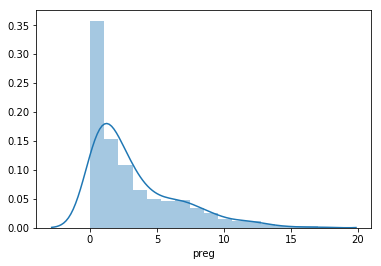

In [10]:
sns.distplot(plot_df.preg)

In [11]:
# readable spearman correlation array
print("""SpearmanrResult(correlation=array([
[ 1.        ,  0.19048148,  0.15241404,  0.05475868,  0.12315371,-0.06555144,  0.01171335,  0.63365655,  0.20023445],
[ 0.19048148,  1.        ,  0.23660931,  0.21583824,  0.65895822,0.19907115,  0.08934581,  0.3503047 ,  0.4987289 ],
[ 0.15241404,  0.23660931,  1.        ,  0.25010618,  0.13163895, 0.31742747, -0.02089194,  0.32924408,  0.19812657],     
[ 0.05475868,  0.21583824,  0.25010618,  1.        ,  0.24114499, 0.67439293,  0.09304947,  0.24150672,  0.26015343],
[ 0.12315371,  0.65895822,  0.13163895,  0.24114499,  1.        , 0.30090608,  0.1315153 ,  0.26074743,  0.37501949],
[-0.06555144,  0.19907115,  0.31742747,  0.67439293,  0.30090608, 1.        ,  0.09624242,  0.1669629 ,  0.26707717],
[ 0.01171335,  0.08934581, -0.02089194,  0.09304947,  0.1315153 , 0.09624242,  1.        ,  0.10298412,  0.19821354],
[ 0.63365655,  0.3503047 ,  0.32924408,  0.24150672,  0.26074743, 0.1669629 ,  0.10298412,  1.        ,  0.39735474],
[ 0.20023445,  0.4987289 ,  0.19812657,  0.26015343,  0.37501949, 0.26707717,  0.19821354,  0.39735474,  1.        ]]))""")
print("left to Right/top to bottom: preg, plas, pres, skin, insu, mass, pedi, age, class")
#age and preg are + correlated (0.634)
#insu and plas are + correlated (0.6589)
#age and plas are slightly + correlated (0.3503047)
#age and pres are slightly + correlated (0.32924408)
#mass and pres are slightly + correlated (0.31742747)
#mass and skin are + correlated (0.67439293)
#mass and insu are slightly + correlated (0.30090608)
#class and insu are + correlated (0.37501949)
#class and age are + correlated (0.39735474)

SpearmanrResult(correlation=array([
[ 1.        ,  0.19048148,  0.15241404,  0.05475868,  0.12315371,-0.06555144,  0.01171335,  0.63365655,  0.20023445],
[ 0.19048148,  1.        ,  0.23660931,  0.21583824,  0.65895822,0.19907115,  0.08934581,  0.3503047 ,  0.4987289 ],
[ 0.15241404,  0.23660931,  1.        ,  0.25010618,  0.13163895, 0.31742747, -0.02089194,  0.32924408,  0.19812657],     
[ 0.05475868,  0.21583824,  0.25010618,  1.        ,  0.24114499, 0.67439293,  0.09304947,  0.24150672,  0.26015343],
[ 0.12315371,  0.65895822,  0.13163895,  0.24114499,  1.        , 0.30090608,  0.1315153 ,  0.26074743,  0.37501949],
[-0.06555144,  0.19907115,  0.31742747,  0.67439293,  0.30090608, 1.        ,  0.09624242,  0.1669629 ,  0.26707717],
[ 0.01171335,  0.08934581, -0.02089194,  0.09304947,  0.1315153 , 0.09624242,  1.        ,  0.10298412,  0.19821354],
[ 0.63365655,  0.3503047 ,  0.32924408,  0.24150672,  0.26074743, 0.1669629 ,  0.10298412,  1.        ,  0.39735474],
[ 0.20023445,  0

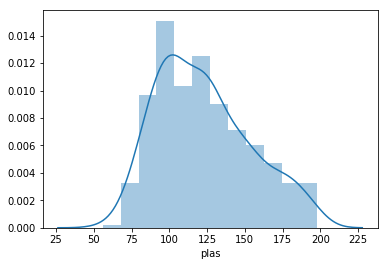

In [12]:
sns.distplot(plot_df.plas)

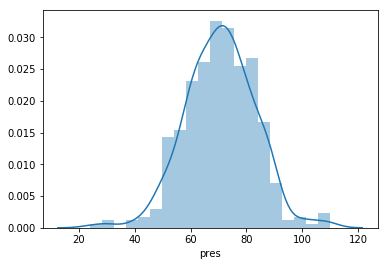

In [13]:
sns.distplot(plot_df.pres)

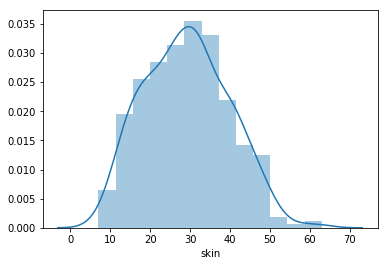

In [14]:
sns.distplot(plot_df.skin)

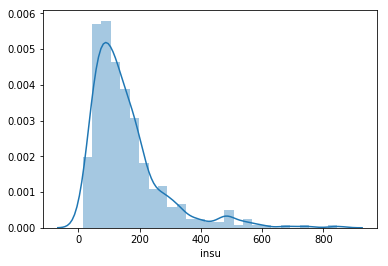

In [15]:
sns.distplot(plot_df.insu)

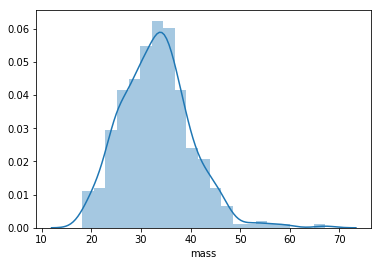

In [16]:
sns.distplot(plot_df.mass)

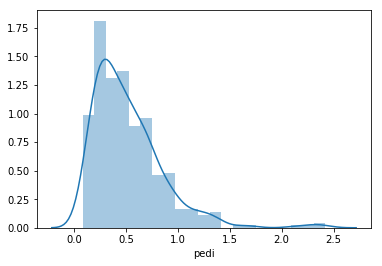

In [17]:
sns.distplot(plot_df.pedi)

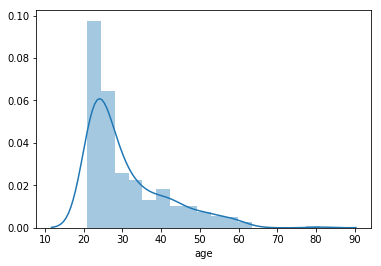

In [18]:
sns.distplot(plot_df.age)

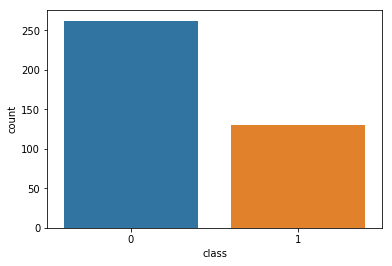

In [19]:
sns.countplot(x="class", data= plot_df)

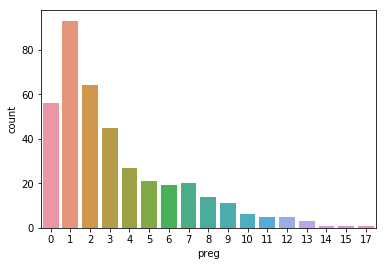

In [20]:
sns.countplot(x="preg", data = plot_df)

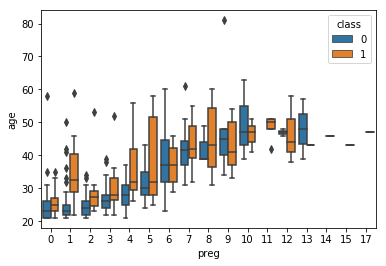

In [21]:
sns.boxplot(x="preg",   y="age", hue="class", data=plot_df)
# Median age increases with pregnancy in independent of diabetic status

LinregressResult(slope=2.1587100153599743, intercept=23.738850102357635, rvalue=0.6796084703853134, pvalue=1.9767881923861096e-54, stderr=0.11799069542379781)

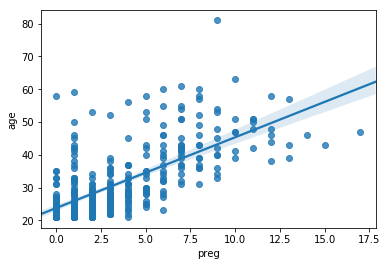

In [22]:
sns.regplot(x="preg", y="age", data=plot_df)
sp.stats.linregress(x=plot_df["preg"], y= plot_df["age"])

LinregressResult(slope=0.04809708187682781, intercept=31.601717873398623, rvalue=0.06981379857867923, pvalue=0.1677368790168348, stderr=0.0348003971041615)

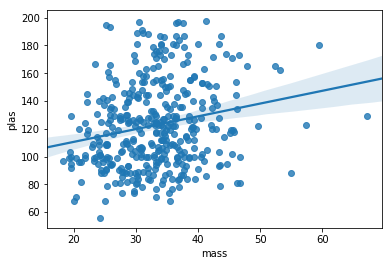

In [23]:
sns.regplot(x="mass", y="plas", data=plot_df)
sp.stats.linregress(x=plot_df["age"], y= plot_df["mass"])

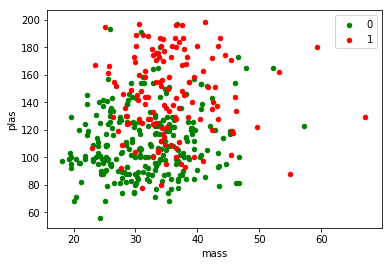

        preg                                                 plas              \
       count      mean       std  min  25%  50%  75%   max  count        mean   
class                                                                           
0      262.0  2.721374  2.617844  0.0  1.0  2.0  4.0  13.0  262.0  111.431298   
1      130.0  4.469231  3.916153  0.0  1.0  3.0  7.0  17.0  130.0  145.192308   

       ...     pedi           age                                           \
       ...      75%    max  count       mean        std   min    25%   50%   
class  ...                                                                   
0      ...  0.62425  2.329  262.0  28.347328   8.989008  21.0  22.00  25.0   
1      ...  0.78650  2.420  130.0  35.938462  10.634705  21.0  27.25  33.0   

                   
        75%   max  
class              
0      30.0  81.0  
1      43.0  60.0  

[2 rows x 64 columns]


In [24]:
fig, ax = plt.subplots()
colors =   {0:'green', 1:'red'}  #green: no diabetes, red: diabetes
grouped = plot_df.groupby('class')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='mass', y='plas', label=key, color=colors[key])
plt.show()
# It appears that diabetic patients have higher blood pressure but the same bmi than nondiabetics
print(grouped.describe())

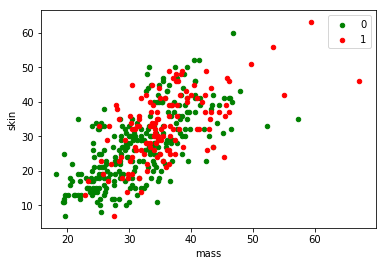

        preg                                                 plas              \
       count      mean       std  min  25%  50%  75%   max  count        mean   
class                                                                           
0      262.0  2.721374  2.617844  0.0  1.0  2.0  4.0  13.0  262.0  111.431298   
1      130.0  4.469231  3.916153  0.0  1.0  3.0  7.0  17.0  130.0  145.192308   

       ...     pedi           age                                           \
       ...      75%    max  count       mean        std   min    25%   50%   
class  ...                                                                   
0      ...  0.62425  2.329  262.0  28.347328   8.989008  21.0  22.00  25.0   
1      ...  0.78650  2.420  130.0  35.938462  10.634705  21.0  27.25  33.0   

                   
        75%   max  
class              
0      30.0  81.0  
1      43.0  60.0  

[2 rows x 64 columns]


In [25]:
fig, ax = plt.subplots()
colors =   {0:'green', 1:'red'}  #green: no diabetes, red: diabetes
grouped = plot_df.groupby('class')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='mass', y='skin', label=key, color=colors[key])
plt.show()
# It appears that diabetic patients have higher blood pressure and bmi than nondiabetics
print(grouped.describe())

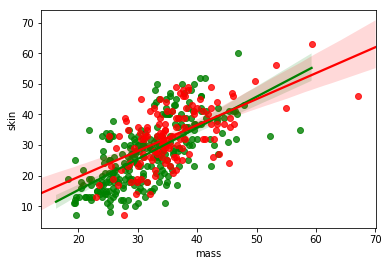

In [26]:
# same plot as above but with regression lines 
#mass and skin are + correlated (0.67439293)
sns.regplot(x="mass", y="skin", data=plot_df[plot_df["class"]==0], color = 'green')
sns.regplot(x="mass", y="skin", data=plot_df[plot_df["class"]==1], color = 'red')

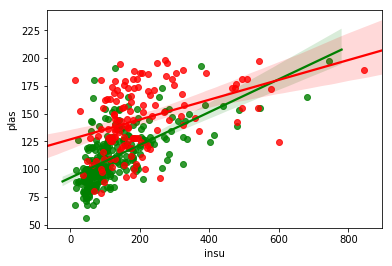

In [27]:
#insu and plas are + correlated (0.6589)
sns.regplot(x="insu", y="plas", data=plot_df[plot_df["class"]==0], color = 'green')
sns.regplot(x="insu", y="plas", data=plot_df[plot_df["class"]==1], color = 'red')
# Glucose levels in diabetic patients are higher at low-med insulin levels

Text(0.5, 1.0, 'insulin levels by diabetic class')

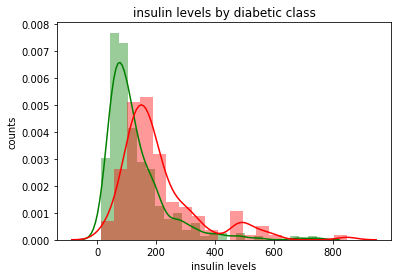

In [28]:
sns.distplot(plot_df["insu"][plot_df["class"]==0], color = "green")
sns.distplot(plot_df["insu"][plot_df["class"]==1], color = "red")
plt.xlabel("insulin levels")
plt.ylabel("counts")
plt.title("insulin levels by diabetic class")
#class and insu are + correlated (0.37501949)
# Insulin levels are higher for diabetics

Text(0.5, 1.0, 'age by diabetic class')

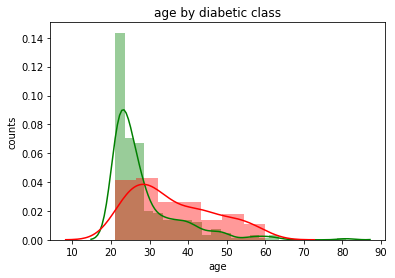

In [29]:
sns.distplot(plot_df["age"][plot_df["class"]==0], color = "green")
sns.distplot(plot_df["age"][plot_df["class"]==1], color = "red")
plt.xlabel("age")
plt.ylabel("counts")
plt.title("age by diabetic class")
#class and age are + correlated (0.39735474)
# wider distribution among diabetes indicates that diabetic populations are more often older

Text(0.5, 1.0, 'mass by diabetic class')

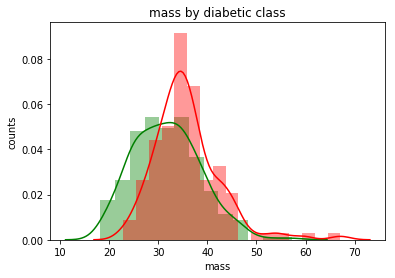

In [30]:
sns.distplot(plot_df["mass"][plot_df["class"]==0], color = "green")
sns.distplot(plot_df["mass"][plot_df["class"]==1], color = "red")
plt.xlabel("mass")
plt.ylabel("counts")
plt.title("mass by diabetic class")
#mass and class are slightly + correlated (0.26707717)
# diabetics appear to have a higher bmi than non-diabetics. 
# Diabetics will thus also have a higher tricep fold thickness(skin) than non-diabetics since mass and skin are + correlated (~0.6)


Text(0.5, 1.0, 'skin fold thickness by diabetic class')

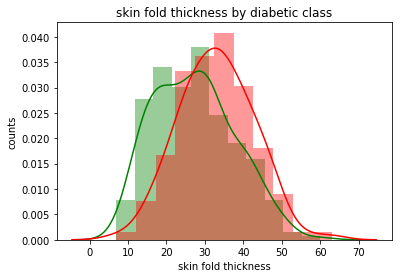

In [31]:
sns.distplot(plot_df["skin"][plot_df["class"]==0], color = "green")
sns.distplot(plot_df["skin"][plot_df["class"]==1], color = "red")
plt.xlabel("skin fold thickness")
plt.ylabel("counts")
plt.title("skin fold thickness by diabetic class")

# creating the machine learning models: (1) RBF kernel

Steps:

1) Do a pairwise correlations to find highly correlated predictor variables. Columns with lots of Nas and/or highly correlated can just be tossed out.

2) Split X attributes and y target into train and test sets. Do not allow any test info to leak into the training set.

3) Impute the data (always impute after splitting train and test sets to prevent test information from leaking into training set)

In [32]:
df2.head(5)

,preg,plas,pres,skin,insu,mass,pedi,age,class
0,6,148.0,72.0,35.0,NaN,33.6,0.627,50,1
1,1,85.0,66.0,29.0,NaN,26.6,0.351,31,0
2,8,183.0,64.0,NaN,NaN,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1


 ### pairwise correlations

In [33]:
df2.describe()

,preg,plas,pres,skin,insu,mass,pedi,age,class
count,768.000000,763.000000,733.000000,541.000000,394.000000,757.000000,768.000000,768.000000,768.000000
mean,3.845052,121.686763,72.405184,29.153420,155.548223,32.457464,0.471876,33.240885,0.348958
std,3.369578,30.535641,12.382158,10.476982,118.775855,6.924988,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,64.000000,22.000000,76.250000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,29.000000,125.000000,32.300000,0.372500,29.000000,0.000000
75%,6.000000,141.000000,80.000000,36.000000,190.000000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


C:\Users\meela\Anaconda3\envs\py35\lib\site-packages\numpy\lib\histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\meela\Anaconda3\envs\py35\lib\site-packages\numpy\lib\histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


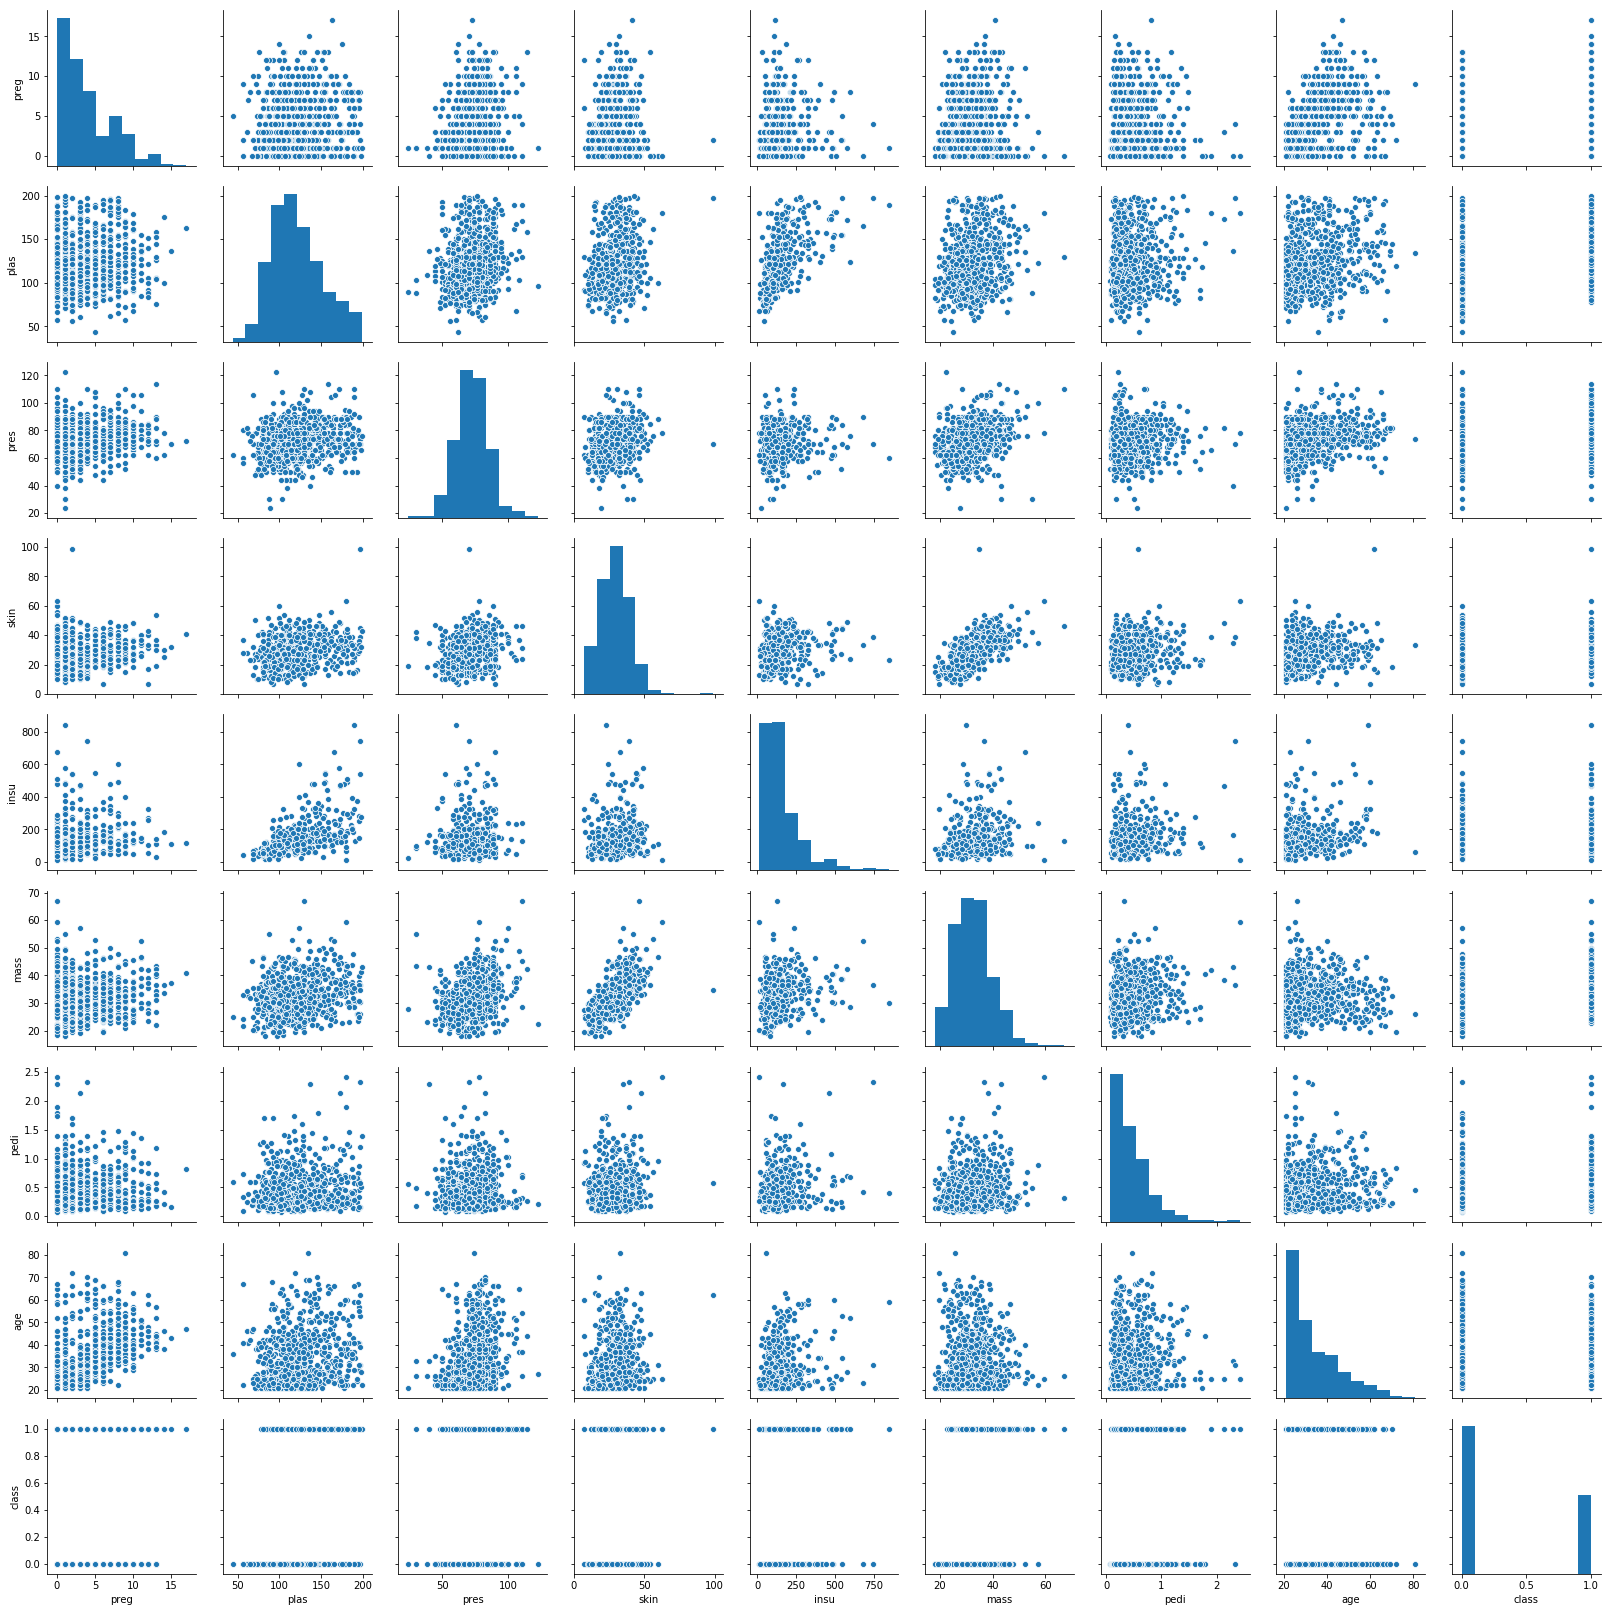

In [34]:
plot_df = sns.pairplot(df2)
# plots the pairwise comparisons of the data
## mass and skin appear correlated
## preg and age appear correlated
## pres and plas appear correlated

In [35]:
# Provides  spearman statistical analyses tests (correlations) for each variable in the table.
cor_data = df2.corr(method = 'spearman')
cor_data
## Both methods above and below will produce the same pairwise correlations.
# correlations = sp.stats.spearmanr(df2, axis = 0, nan_policy = 'omit') 
# left to Right: preg,plas, pres, skin, insu,mass,pedi,age,class

# However, do NOT use df.dropna(). This drops ALL rows containing NA values, losing vast amounts of data for columns with many NA values.


,preg,plas,pres,skin,insu,mass,pedi,age,class
preg,1.000000,0.129547,0.194103,0.086734,0.127859,0.000279,-0.043242,0.607216,0.198689
plas,0.129547,1.000000,0.249415,0.229815,0.658813,0.227761,0.090596,0.283315,0.483364
pres,0.194103,0.249415,1.000000,0.248017,0.130463,0.299176,0.008511,0.370609,0.177227
skin,0.086734,0.229815,0.248017,1.000000,0.245188,0.685380,0.074979,0.231132,0.265397
insu,0.127859,0.658813,0.130463,0.245188,1.000000,0.303515,0.130262,0.267437,0.377300
mass,0.000279,0.227761,0.299176,0.685380,0.303515,1.000000,0.136138,0.121119,0.309324
pedi,-0.043242,0.090596,0.008511,0.074979,0.130262,0.136138,1.000000,0.042909,0.175353
age,0.607216,0.283315,0.370609,0.231132,0.267437,0.121119,0.042909,1.000000,0.309040
class,0.198689,0.483364,0.177227,0.265397,0.377300,0.309324,0.175353,0.309040,1.000000


In [36]:
# Columns with lots of Nas and are highly correlated might be tossed out.
print(df2.sum())
print()
print(df2.isna().sum())
#age and preg are + correlated (0.634)
#insu and plas are + correlated (0.6589)
#age and plas are slightly + correlated (0.3503047)
#age and pres are slightly + correlated (0.32924408)
#mass and pres are slightly + correlated (0.31742747)
#mass and skin are + correlated (0.67439293)
#mass and insu are slightly + correlated (0.30090608)
#class and insu are + correlated (0.37501949)
#class and age are + correlated (0.39735474)

print("Potential colinear predictors: \n age and preg \n insu and plas \n mass and skin")

preg      2953.000
plas     92847.000
pres     53073.000
skin     15772.000
insu     61286.000
mass     24570.300
pedi       362.401
age      25529.000
class      268.000
dtype: float64

preg       0
plas       5
pres      35
skin     227
insu     374
mass      11
pedi       0
age        0
class      0
dtype: int64
Potential colinear predictors: 
 age and preg 
 insu and plas 
 mass and skin


# Separate class label from predictor variables, create train and test sets, and stratify the data:
X : dataframe containing predictor variables, unlabeled with class.

y : dataframe containing class labels for X

Stratification divides members of the population into homogeneous subgroups before sampling for training/test sets.

The strata should be mutually exclusive: every element in the population must be assigned to only one stratum.

In [37]:
X = df2.drop(labels=["class"], axis= 1) # axis is DIMENSION. 0 = rows, 1 = columns
print(X.head(5)) # dataframe X containing predictor variables only
print()

y = df2.loc[:,"class"]  # Note: You can also use iloc for index based data selection
print()
print(y.head(5)) # dataframe y containing response variable (class labels) for X"
print(y.unique())

X_col_names = X.columns.values
print(X_col_names)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)
len(X_train)

   preg   plas  pres  skin   insu  mass   pedi  age
0     6  148.0  72.0  35.0    NaN  33.6  0.627   50
1     1   85.0  66.0  29.0    NaN  26.6  0.351   31
2     8  183.0  64.0   NaN    NaN  23.3  0.672   32
3     1   89.0  66.0  23.0   94.0  28.1  0.167   21
4     0  137.0  40.0  35.0  168.0  43.1  2.288   33


0    1
1    0
2    1
3    0
4    1
Name: class, dtype: int64
[1 0]
['preg' 'plas' 'pres' 'skin' 'insu' 'mass' 'pedi' 'age']


537

### Random seed and randomly select indices
Set random seed for repeatability of experiment.
Randomly set indices from the diab_x dataset. A defined random seed will make sure that the same indices are set each time.

In [38]:
np.random.seed(0) # makes the random numbers predictable so that the same set of numbers will appear every time.
indices = np.random.permutation(len(X_train)) # randomly selects indices from the diabetes (reproducible with np.random.seed(0))
print(indices)
print(len(indices))
len(X_train)
len(X)

[172 466 196 416 533 210 489 236 318 162 281  71 531 477 108 412 422 289
 379  78 140 399 134 518 211 374 247 299  45  15 188 153 229 337  17 102
 421 142 245 366 159 348 246 165 206 424 529 107 338 155 497 126  46 419
 350  96  37  21  66 375 505 315  90 428 194  85 303 239  75 362 465 340
 185 463 372 517 343 339 249 450 432 263 190 464 261 333   1 367  12 132
 103 381 240  76 298 302 268 220 313 312 316 493 365 491 225 336 457  10
 467 208 250 157 118  65 391 501 112 441 447 238 284 213 310 407 137 534
 113 390   7 380 484 393 524 271 101  97 202  54  30 205  49 100 278 436
 272  56 144  60   6   8 342 200 282 175 536 502 522 437 361 301 243 252
 124 154 386  59 233 451 476 532 308 179  55 171 490 158 230  34 354  18
 378 351 285  52  74  26 173  92 167   4 364 181 415 429   5 141 440 135
 283 122  22  68  20 500  14 170 319 499 345 471  64 513 231 120  81 408
 346 439 293 525 519 160 527 417 264 469 344 456  51 195 191 116 330 382
 164 106 535  63 470 395 186 496 276 235 509 332 21

768

## Impute and transform the dataset

1) Impute the dataset

2) Fit AND transform training set- transform the test set on a scale fitted to the training set


In [39]:
# Class Imputer is deprecated --> next cell uses SimpleImputer from sklearn
# Impute the dataset, then fit AND transform training set
# I transform the test set on a scale fitted to the training set
# imp_x = Imputer(missing_values='NaN', strategy='median', axis=0) 
# X_train = imp_x.fit_transform(X_train)# # fit AND transform training set
# X_test = imp_x.transform(X_test) # transform test set on scale fitted to training set
# print(X_train)
# print()
# print(X_test)
# print()
# print(len(y_train))

In [40]:
# Impute the dataset, then fit AND transform training set
# I transform the test set on a scale fitted to the training set

imp_x = SimpleImputer(missing_values = np.nan, strategy='median') 
X_train = imp_x.fit_transform(X_train)# # fit AND transform training set
X_test = imp_x.transform(X_test) # transform test set on scale fitted to training set
print(X_train)
print()
print(X_test)
print()
print(len(y_train))

[[5.00e+00 1.09e+02 6.20e+01 ... 3.58e+01 5.14e-01 2.50e+01]
 [1.00e+00 9.70e+01 7.00e+01 ... 3.81e+01 2.18e-01 3.00e+01]
 [8.00e+00 1.00e+02 7.40e+01 ... 3.94e+01 6.61e-01 4.30e+01]
 ...
 [1.00e+01 1.29e+02 6.20e+01 ... 4.12e+01 4.41e-01 3.80e+01]
 [0.00e+00 9.30e+01 6.00e+01 ... 2.87e+01 5.32e-01 2.20e+01]
 [2.00e+00 1.57e+02 7.40e+01 ... 3.94e+01 1.34e-01 3.00e+01]]

[[  0.    131.     66.    ...  34.3     0.196  22.   ]
 [  0.    165.     90.    ...  52.3     0.427  23.   ]
 [  7.    102.     74.    ...  37.2     0.204  45.   ]
 ...
 [  1.    172.     68.    ...  42.4     0.702  28.   ]
 [  5.    158.     84.    ...  39.4     0.395  29.   ]
 [  4.    151.     90.    ...  29.7     0.294  36.   ]]

537


The code below is used for imputing the class, y. In this dataset, there are no missing values that require imputation. If there were missing values in the class variable, I could impute NA values with the most commonly occurring value in the training targets.

In [41]:
#(_, idx, counts) = np.unique(y_train, return_index=True, return_counts=True)
#print _, idx, counts
#index = idx[np.argmax(counts)]
## find the index of mode (ie: most commonly occuring value)
#mode = y_train[index] 
## find the mode
#print index, mode
##Impute the mode to both the train and test target NAs
#y_train[y_train==0] = mode
#y_test[y_test==0] = mode

In [42]:
# Support vector classifier before scaling data
svc = SVC(kernel='rbf', class_weight='balanced', cache_size=1000, probability=True, gamma = "auto") # instantiates a SVM classifier
#  class_weight: The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data. 
# cache_size will specify the size of the kernel cache 
print(svc)
clf = svc.fit(X_train, y_train) # trains the classifier on the training set
y_pred = svc.predict(X_test) # tests the classifier on the test set
pTot = accuracy_score(y_test, y_pred)
print("Prediction accuracy: ",pTot)

SVC(C=1.0, cache_size=1000, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Prediction accuracy:  0.645021645021645


In [43]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[149,   1],
       [ 81,   0]], dtype=int64)

In [44]:
## CLASSIFIER REPORT 
# Shows the main classification metrics for each class in the test set, and what was predicted by the model.
# precision(Positive predictive value--PPV--# of true diabetics over all predicted as diabetic)
# recall(sensitivity, # of corrrecttly identified diabetics over all diabetics)  
# f1-score: balance between the precision and the recall 
# support: number of true instances for each label

report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.65      0.99      0.78       150
           1       0.00      0.00      0.00        81

   micro avg       0.65      0.65      0.65       231
   macro avg       0.32      0.50      0.39       231
weighted avg       0.42      0.65      0.51       231



## Scaling the data

Data is scaled on the trainig set, then that scale is applied to the test set.

Scaling takes every column and scales the minimum and max fairly from 0 to 1, making sure that there is no leaking of test info into the training set


In [45]:
print(X_test) #to compare before/after scaling
min_max_scaler = MinMaxScaler()
X_train_minmax = min_max_scaler.fit_transform(X_train)# fits and transforms training set
X_test_minmax = min_max_scaler.transform(X_test)# test set transform only, no fit
X_test_minmax

[[  0.    131.     66.    ...  34.3     0.196  22.   ]
 [  0.    165.     90.    ...  52.3     0.427  23.   ]
 [  7.    102.     74.    ...  37.2     0.204  45.   ]
 ...
 [  1.    172.     68.    ...  42.4     0.702  28.   ]
 [  5.    158.     84.    ...  39.4     0.395  29.   ]
 [  4.    151.     90.    ...  29.7     0.294  36.   ]]


array([[0.        , 0.56493506, 0.45      , ..., 0.3907767 , 0.04794521,
        0.01666667],
       [0.        , 0.78571429, 0.75      , ..., 0.8276699 , 0.14683219,
        0.03333333],
       [0.41176471, 0.37662338, 0.55      , ..., 0.46116505, 0.05136986,
        0.4       ],
       ...,
       [0.05882353, 0.83116883, 0.475     , ..., 0.58737864, 0.26455479,
        0.11666667],
       [0.29411765, 0.74025974, 0.675     , ..., 0.51456311, 0.13313356,
        0.13333333],
       [0.23529412, 0.69480519, 0.75      , ..., 0.27912621, 0.08989726,
        0.25      ]])

##  Fitting the support vector classification

In [46]:
svc = SVC(kernel='rbf', class_weight='balanced', cache_size=1000, probability=True, gamma = "auto") 

print(svc) # calls SVC __str__ to view all the attibutes, including the default parameters that are used 
clf = svc.fit(X_train_minmax, y_train) # trains the classifier on the training set
y_pred_minmax = svc.predict(X_test_minmax) # tests the classifier on the test set
pTot = accuracy_score(y_test, y_pred_minmax)
print("Prediction accuracy: ",pTot)

SVC(C=1.0, cache_size=1000, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Prediction accuracy:  0.7402597402597403


## Classifier report
Shows the main classification metrics for each class in the test set, and what was predicted by the model.

precision(Positive predictive value--PPV--# of true diabetics over all predicted as diabetic)

recall(sensitivity, # of corrrecttly identified diabetics over all diabetics)  

f1-score: balance between the precision and the recall 

support: number of true instances for each label

In [47]:
## CLASSIFIER REPORT 
# Shows the main classification metrics for each class in the test set, and what was predicted by the model.
# precision(Positive predictive value--PPV--# of true diabetics over all predicted as diabetic)
# recall(sensitivity, # of corrrecttly identified diabetics over all diabetics)  
# f1-score: balance between the precision and the recall 
# support: number of true instances for each label
cm = confusion_matrix(y_test, y_pred_minmax)
print(cm)
report = classification_report(y_test, y_pred_minmax)
print(report) #for each class prints: precision  recall  f1-score   support

[[118  32]
 [ 28  53]]
              precision    recall  f1-score   support

           0       0.81      0.79      0.80       150
           1       0.62      0.65      0.64        81

   micro avg       0.74      0.74      0.74       231
   macro avg       0.72      0.72      0.72       231
weighted avg       0.74      0.74      0.74       231



# ROC curve 
false positive rate / true positive rate at different thresholds


In [48]:
# Here we are fitting the SVC using the rbf parameters that we setup. 
## Then we are supplying the SVC with the scaled X and y training set to predict the probabilites of being diabetic in the test set.
probas_ = svc.fit(X_train_minmax, y_train).predict_proba(X_test_minmax)

# Here we are extracting the model's ability to predict as diabetic and nondiabetic of the test set using the trained model.
fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])  # Using the probas of (diabetic) and nondiabetic
### Here we are getting the false positive rate(fpr), and true positive rate(tpr) at EACH threshold of the ROC curve.
#### As we adjust the threshold, the fpr and tpr will also change.
roc_auc = auc(fpr, tpr)
print("thresholds", thresholds)
print
print("probas_", probas_) # probabilities
print
print("AUC using predict_proba", roc_auc)
### we have printed the probability of a diabetic class at each threshold in the model.
### And we have determined the area under the curve in the ROC. (roc_auc)
##### The area under the ROC curve is 0.8074074074074075.

thresholds [1.96685814 0.96685814 0.91387639 0.90908776 0.85012219 0.83567572
 0.80719701 0.79889522 0.73640905 0.72320095 0.69470823 0.68561855
 0.6794398  0.674333   0.64739363 0.64685773 0.64041624 0.62868672
 0.62860903 0.60541053 0.59632845 0.59129194 0.53847493 0.53782202
 0.5239482  0.49081545 0.48843443 0.48274625 0.481674   0.4640366
 0.45472337 0.42415851 0.42182162 0.41722601 0.39309524 0.38943243
 0.36905707 0.362706   0.35839382 0.32887151 0.32842748 0.3281726
 0.31564827 0.31426483 0.30296594 0.30227444 0.29936107 0.29797847
 0.28808749 0.28780326 0.282536   0.27328112 0.27262182 0.27150101
 0.26696818 0.261285   0.24631937 0.22389934 0.22123062 0.21770653
 0.21463676 0.20777742 0.20620798 0.1994817  0.1985996  0.19621424
 0.19404633 0.19018778 0.18994077 0.185377   0.18304549 0.15553338
 0.1516046  0.14588874 0.14230679 0.14071002 0.13786987 0.0931087
 0.09090255 0.04696555 0.04689246 0.02139228]
probas_ [[0.81695451 0.18304549]
 [0.15594672 0.84405328]
 [0.68573517 0.31

In [49]:
%matplotlib inline  
# makes matplotlib funcitons output print inline

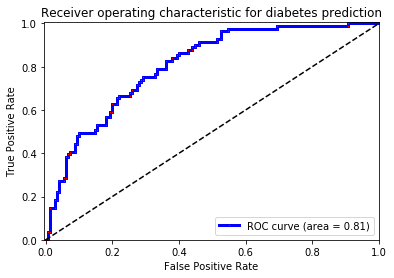

In [50]:
# Plotting the ROC curve
## The ROC curve illustrates the model's diagnostic ability to predict in a binary system, in this case, diabetic or not diabetic.

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, lw=3, color ="#0000ff", marker='s',markerfacecolor="red", markersize=2) 
#### plots the ROC curve values based on the false positive and true positve rate that were calculated from the train/test set

plt.plot([0, 1], [0, 1], 'k--') # also plot black dashed line (k=black) from (0,0) to (1,1)
#### labels the "coin flip" curve/outcome, which is the worst possible outcome, onto the figure

# Set x and y ranges, labels, title and legend
plt.xlim([-0.005, 1.0])  #x range basically from 0 to 1: start range a bit to left of min x value to see thick line better
plt.ylim([0.0, 1.005])   #y range basically from 0 to 1: extend range a bit above max y value to see thick line better
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for diabetes prediction')
plt.legend(loc="lower right")
plt.show()

### Parameter tuning: C and gamma 

Gamma parameter defines how far the influence of a single training example reaches. Low = far reach. High = close reach.

Low gamma values are "far" reaching, so points that are far away still carry weight on the decision bondary, while high gamma values are "close" reaching, so points near the decision boundary carry more weight and thus more influence on the decision boundary than points that are far away. Therefore, a low gamma means values will produce a less flexible decision boundary while high gamma means the decision boundary will be more jagged and thus flexible because it includes the influence of points near the boundary (can lead to overfitting).


The C parameter trades off correct classification of training examples against maximization of the decision. Controls the trade-off between a smooth decision boundary and one that accurately predicts it (more flexible). 
Large C values accept a smaller margin, so the decision function is better at classifying all training points correctly (more flexible, potential for overfitting and becomes less generalizable). 
Small C encourages a larger margin, and thus a simpler decision function, at the cost of training accuracy (less flexible, more generalizable but also less accurate on the training set).

rule of thumb: High gamma and high C both lead to 'tighter' decision boundaries, and vice-versa. 


In [51]:
C_range = 10.0 ** np.arange(-2, 4)
print(C_range)
# gamma_range = 10.0 ** np.arange(-3, 3)
## 'auto' is 1/(# of predictor variables) 
gamma_range = [.01, .1, 1, 'auto', 10, 100]
print(gamma_range)
param_grid = dict(gamma=gamma_range, C=C_range)
param_grid

[1.e-02 1.e-01 1.e+00 1.e+01 1.e+02 1.e+03]
[0.01, 0.1, 1, 'auto', 10, 100]


{'gamma': [0.01, 0.1, 1, 'auto', 10, 100],
 'C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])}

## Cross-validation grid search

Optimize the classifer after creating the initial model

Find the optimal C and gamma to use 

In [52]:
# Default is 3-fold cross validation
grid = GridSearchCV(SVC(kernel='rbf',cache_size=1000, probability=True), param_grid=param_grid, cv = 3) 

grid.fit(X_train_minmax, y_train)# runs the grid search on the training data only
best_C = grid.best_estimator_.C
best_gamma = grid.best_estimator_.gamma
print("The best C and gamma for rbf is: %.5f, %.5f " % (best_C, best_gamma))
grid.best_estimator_

The best C and gamma for rbf is: 100.00000, 0.10000 


SVC(C=100.0, cache_size=1000, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [53]:
best_predict_minmax = grid.best_estimator_.predict(X_test_minmax)
pTot = accuracy_score(y_test, best_predict_minmax)
print("Prediction accuracy: ",pTot)
cm = confusion_matrix(y_test, best_predict_minmax)
print(cm) #confusion matrix
report = classification_report(y_test, best_predict_minmax)
print(report) #for each class prints: precision  recall  f1-score   support

## Here we can see that using the best C and gamma estimators, we determine a prediction accuracy of ~0.758

Prediction accuracy:  0.7575757575757576
[[135  15]
 [ 41  40]]
              precision    recall  f1-score   support

           0       0.77      0.90      0.83       150
           1       0.73      0.49      0.59        81

   micro avg       0.76      0.76      0.76       231
   macro avg       0.75      0.70      0.71       231
weighted avg       0.75      0.76      0.74       231



precision(PPV,# of true diabetics over all predicted as diabetic)

recall(sensitivity, # of corrrectly identified diabetics over all diabetics)

f1-score: balance between the precision and the recall 

support: number of true instances for each label:


In [54]:
test_svc = SVC(C=best_C, gamma=best_gamma, kernel='rbf', cache_size=1000, probability=True) 
clf_test = test_svc.fit(X_train_minmax, y_train) # trains the classifier on the training set
y_pred_minmax_test = test_svc.predict(X_test_minmax) # tests the classifier on the test set
pTot = accuracy_score(y_test, y_pred_minmax_test)
print("Prediction accuracy: ",pTot)

Prediction accuracy:  0.7575757575757576


In [55]:
cm = confusion_matrix(y_test, y_pred_minmax_test)
# TN FP
# FN TP
print(cm)
report = classification_report(y_test, y_pred_minmax_test)
print(report) #for each class prints: precision  recall  f1-score   support

[[135  15]
 [ 41  40]]
              precision    recall  f1-score   support

           0       0.77      0.90      0.83       150
           1       0.73      0.49      0.59        81

   micro avg       0.76      0.76      0.76       231
   macro avg       0.75      0.70      0.71       231
weighted avg       0.75      0.76      0.74       231



In [56]:
probas_ = svc.fit(X_train_minmax, y_train).predict_proba(X_test_minmax)
fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])  # use the probs of (smoke), not of nonsmoking
roc_auc = auc(fpr, tpr)
print("AUC using predict_proba", roc_auc)
probas_
# AUC is 0.8150617283950617

AUC using predict_proba 0.8074897119341563


array([[0.81781239, 0.18218761],
       [0.14430986, 0.85569014],
       [0.68227611, 0.31772389],
       [0.96439069, 0.03560931],
       [0.60266578, 0.39733422],
       [0.75261581, 0.24738419],
       [0.08224791, 0.91775209],
       [0.51806424, 0.48193576],
       [0.59023537, 0.40976463],
       [0.90934994, 0.09065006],
       [0.85591412, 0.14408588],
       [0.32486805, 0.67513195],
       [0.94927664, 0.05072336],
       [0.50896133, 0.49103867],
       [0.96936852, 0.03063148],
       [0.94522839, 0.05477161],
       [0.84459823, 0.15540177],
       [0.80428077, 0.19571923],
       [0.68481391, 0.31518609],
       [0.93704403, 0.06295597],
       [0.50868161, 0.49131839],
       [0.77576412, 0.22423588],
       [0.66795234, 0.33204766],
       [0.13534536, 0.86465464],
       [0.17123591, 0.82876409],
       [0.22628547, 0.77371453],
       [0.53680204, 0.46319796],
       [0.73527157, 0.26472843],
       [0.35745303, 0.64254697],
       [0.6045419 , 0.3954581 ],
       [0.

# creating the machine learning models: (2) linear kernel

In [57]:
# Fitting the support vector classification

svc = SVC(kernel='linear', class_weight='balanced', cache_size=1000, probability=True) # instantiates a SVM classifier
#  class_weight: The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data. 
# cashe_size will specify the size of the kernel cache 
print(svc)
clf = svc.fit(X_train_minmax, y_train) # trains the classifier on the training set
y_pred = svc.predict(X_test_minmax) # tests the classifier on the test set
pTot = accuracy_score(y_test, y_pred)
print("Prediction accuracy: ",pTot)

SVC(C=1.0, cache_size=1000, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)
Prediction accuracy:  0.7316017316017316


In [58]:
cm = confusion_matrix(y_test, y_pred_minmax)
print(cm)
report = classification_report(y_test, y_pred_minmax)
print(report) #for each class prints: precision  recall  f1-score   support

[[118  32]
 [ 28  53]]
              precision    recall  f1-score   support

           0       0.81      0.79      0.80       150
           1       0.62      0.65      0.64        81

   micro avg       0.74      0.74      0.74       231
   macro avg       0.72      0.72      0.72       231
weighted avg       0.74      0.74      0.74       231



Here we are fitting the SVC using the linear parameters that we setup. 

Then we are supplying the SVC with the scaled X and y training set to predict the probabilites of being diabetic in the test set.


In [59]:
probas_ = svc.fit(X_train_minmax, y_train).predict_proba(X_test_minmax)
# Here we are extracting the model's ability to predict as diabetic and nondiabetic of the test set using the trained model.

fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])  # Using the probas of (diabetic) and nondiabetic
### Here we are getting the false positive rate(fpr), and true positive rate(tpr) at EACH threshold of the ROC curve.
#### As we adjust the treshold, the fpr and tpr will also change.
roc_auc = auc(fpr, tpr)
print("thresholds", thresholds)
print
print("probas_", probas_) # probabilities
print
print("AUC using predict_proba", roc_auc)
### we have printed the probability of a diabetic class at each threshold in the model.
### And we have determined the area under the curve in the ROC. (roc_auc)
##### The area under the ROC curve is 0.8151440329218107.

thresholds [1.99224565 0.99224565 0.94777261 0.94168059 0.91706806 0.91647175
 0.85047336 0.84890465 0.82896415 0.81389228 0.75323661 0.7374235
 0.72995074 0.72744146 0.69392804 0.69308588 0.66311629 0.66284706
 0.66030593 0.65962363 0.61726219 0.61250886 0.58730596 0.58547979
 0.58110326 0.5752816  0.56896822 0.51852914 0.51471938 0.50591758
 0.5        0.48475348 0.47065768 0.46094892 0.44266112 0.44056296
 0.42619438 0.41717839 0.41160078 0.40779171 0.40669743 0.40397808
 0.39010831 0.38742679 0.34566499 0.33480209 0.3341908  0.33368627
 0.31954834 0.31011124 0.29929706 0.2963803  0.26714893 0.26562523
 0.2554413  0.24914412 0.24668447 0.24526553 0.23237053 0.23222773
 0.23019071 0.22910632 0.21401146 0.21119379 0.19601004 0.19343431
 0.1920587  0.19180529 0.18903811 0.18510611 0.18394896 0.1768702
 0.17397116 0.16439342 0.14017482 0.13992394 0.10388094 0.10294031
 0.04687136 0.04635882 0.01731697]
probas_ [[0.80656569 0.19343431]
 [0.08352825 0.91647175]
 [0.70577506 0.29422494]
 [

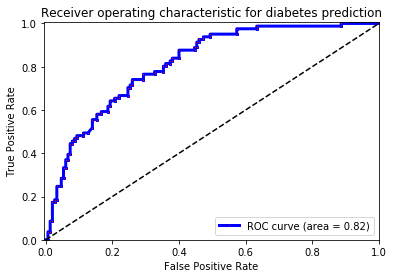

In [60]:
# Plotting the ROC curve
## The ROC curve illustrates the model's diagnostic ability to predict in a binary system, in this case, diabetic or not diabetic.

plt.figure()

plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, lw=3, color ="#0000ff", marker='s',markerfacecolor="red", markersize=2) 
#### plots the ROC curve values based on the false positive and true positve rate that were calculated from the train/test set

plt.plot([0, 1], [0, 1], 'k--') # also plot black dashed line (k=black) from (0,0) to (1,1)
#### labels the "coin flip" curve/outcome, which is the worst possible outcome, onto the figure

# Set x and y ranges, labels, title and legend
plt.xlim([-0.005, 1.0])  #x range basically from 0 to 1: start range a bit to left of min x value to see thick line better
plt.ylim([0.0, 1.005])   #0 range basically from 0 to 1: extend range a bit above max y value to see thick line better
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for diabetes prediction')
plt.legend(loc="lower right")
plt.show()

In [61]:
### Parameter tuning 
C_range = 10.0 ** np.arange(-2, 4)
#gamma_range = 10.0 ** np.arange(-3, 3)
## 'auto' is 1/(# of predictor variables) 
gamma_range = [.01, .1, 1, 'auto', 10, 100]
print(gamma_range)
param_grid = dict(gamma=gamma_range, C=C_range)
param_grid

[0.01, 0.1, 1, 'auto', 10, 100]


{'gamma': [0.01, 0.1, 1, 'auto', 10, 100],
 'C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])}

In [62]:
#### Doing a cross-validation gridsearch to optimize the classifier after creating the initial model.
### Here find the optimal C and gamma to use 

# Gamma parameter defines how far the influence of a single training example reaches
## low values are "far" reaching and high values are "close". 

# The C parameter trades off correct classification of training examples against maximization of the decision.
# Large C values accept a smaller margin if the decision function is better at classifying all training points correctly. 
# Small C encourages a larger margin, and thus a simpler decision function, at the cost of training accuracy. 

# Default is 3-fold cross validation
grid = GridSearchCV(SVC(kernel='linear',cache_size=1000, probability=True), param_grid=param_grid, cv = 3) 

grid.fit(X_train_minmax, y_train)# runs the grid search on the training data only
best_C = grid.best_estimator_.C
best_gamma = grid.best_estimator_.gamma
print("The best C and gamma for linear is: %.5f, %.5f " % (best_C, best_gamma))
grid.best_estimator_

The best C and gamma for linear is: 1.00000, 0.01000 


SVC(C=1.0, cache_size=1000, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [63]:
best_predict_minmax = grid.best_estimator_.predict(X_test_minmax)
pTot = accuracy_score(y_test, best_predict_minmax)
print("Prediction accuracy: ",pTot)
cm = confusion_matrix(y_test, best_predict_minmax)
print(cm) #confusion matrix
report = classification_report(y_test, best_predict_minmax)
print(report) #for each class prints: precision  recall  f1-score   support
# precision(PPV,# of true diabetics over all predicted as diabetic)
# recall(sensitivity, # of corrrectly identified diabetics over all diabetics)  
# f1-score: balance between the precision and the recall 
# support: number of true instances for each label:

## Here we can see that using the best C and gamma estimators, we determine a prediction accuracy of ~0.758

Prediction accuracy:  0.7489177489177489
[[134  16]
 [ 42  39]]
              precision    recall  f1-score   support

           0       0.76      0.89      0.82       150
           1       0.71      0.48      0.57        81

   micro avg       0.75      0.75      0.75       231
   macro avg       0.74      0.69      0.70       231
weighted avg       0.74      0.75      0.73       231



In [64]:
#The best estimated C and gamma were 1.0 and 0.01, respectively.
test_svc = SVC(C=best_C, gamma=best_gamma ,kernel='linear', cache_size=1000, probability=True) 
clf_test = test_svc.fit(X_train_minmax, y_train) # trains the classifier on the training set
y_pred_minmax_test = test_svc.predict(X_test_minmax) # tests the classifier on the test set
pTot = accuracy_score(y_test, y_pred_minmax_test)
print("Prediction accuracy: ",pTot)

Prediction accuracy:  0.7489177489177489


In [65]:
cm = confusion_matrix(y_test, y_pred_minmax_test)
# TN FP
# FN TP
print(cm)
report = classification_report(y_test, y_pred_minmax_test)
print(report) #for each class prints: precision  recall  f1-score   support

[[134  16]
 [ 42  39]]
              precision    recall  f1-score   support

           0       0.76      0.89      0.82       150
           1       0.71      0.48      0.57        81

   micro avg       0.75      0.75      0.75       231
   macro avg       0.74      0.69      0.70       231
weighted avg       0.74      0.75      0.73       231



In [66]:
probas_ = svc.fit(X_train_minmax, y_train).predict_proba(X_test_minmax)
fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])  # use the probs of (smoke), not of nonsmoking
roc_auc = auc(fpr, tpr)
print("AUC using predict_proba", roc_auc)
#probas_
# AUC is 0.8149794238683128

AUC using predict_proba 0.8151440329218107


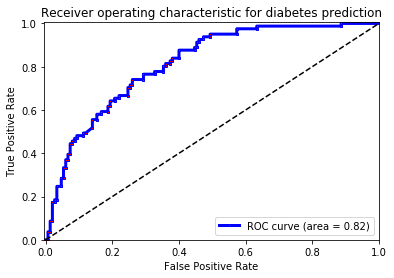

In [67]:
# Plotting the ROC curve
## The ROC curve illustrates the model's diagnostic ability to predict in a binary system, in this case, diabetic or not diabetic.

plt.figure()

plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, lw=3, color ="#0000ff", marker='s',markerfacecolor="red", markersize=2) 
#### plots the ROC curve values based on the false positive and true positve rate that were calculated from the train/test set

plt.plot([0, 1], [0, 1], 'k--') # also plot black dashed line (k=black) from (0,0) to (1,1)
#### labels the "coin flip" curve/outcome, which is the worst possible outcome, onto the figure


# Set x and y ranges, labels, title and legend
plt.xlim([-0.005, 1.0])  #x range basically from 0 to 1: start range a bit to left of min x value to see thick line better
plt.ylim([0.0, 1.005])   #0 range basically from 0 to 1: extend range a bit above max y value to see thick line better
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for diabetes prediction')
plt.legend(loc="lower right")
plt.show()

# creating the machine learning model: (3) quadratic [degree 2] polynomial kernel
    

In [68]:
# Fitting the support vector classification

svc = SVC(kernel='poly', degree = 2, class_weight='balanced', cache_size=1000, probability=True, gamma = "auto") # instantiates a SVM classifier
#  class_weight: The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data. 
# cashe_size will specify the size of the kernel cache 
print(svc)
clf = svc.fit(X_train_minmax, y_train) # trains the classifier on the training set
y_pred = svc.predict(X_test_minmax) # tests the classifier on the test set
pTot = accuracy_score(y_test, y_pred)
print("Prediction accuracy: ",pTot)

SVC(C=1.0, cache_size=1000, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=2, gamma='auto', kernel='poly',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Prediction accuracy:  0.7142857142857143


In [69]:
cm = confusion_matrix(y_test, y_pred_minmax)
print(cm)
report = classification_report(y_test, y_pred_minmax)
print(report) #for each class prints: precision  recall  f1-score   support

[[118  32]
 [ 28  53]]
              precision    recall  f1-score   support

           0       0.81      0.79      0.80       150
           1       0.62      0.65      0.64        81

   micro avg       0.74      0.74      0.74       231
   macro avg       0.72      0.72      0.72       231
weighted avg       0.74      0.74      0.74       231



In [70]:
### ROC curve / false positive rate / true positive rate at different thresholds
# Here we are fitting the SVC using the linear parameters that we setup. 
## Then we are supplying the SVC with the scaled X and y training set to predict the probabilites of being diabetic in the test set.


probas_ = svc.fit(X_train_minmax, y_train).predict_proba(X_test_minmax)
# Here we are extracting the model's ability to predict as diabetic and nondiabetic of the test set using the trained model.

fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])  # Using the probas of (diabetic) and nondiabetic
### Here we are geting the false positive rate(fpr), and true positive rate(tpr) at EACH threshold of the ROC curve.
#### As we adjust the treshold, the fpr and tpr will also change.
roc_auc = auc(fpr, tpr)
print("thresholds", thresholds)
print
print("probas_", probas_) # probabilities
print
print("AUC using predict_proba", roc_auc)
### we have printed the probability of a diabetic class at each threshold in the model.
### And we have determined the area under the curve in the ROC. (roc_auc)
##### The area under the ROC curve is 0.8074074074074075.

thresholds [1.99581391 0.99581391 0.96362951 0.96054928 0.93632225 0.92984601
 0.82025229 0.81577093 0.77425055 0.76681623 0.73921576 0.71680833
 0.66687363 0.65614678 0.64370826 0.63961028 0.62485455 0.62437251
 0.61581393 0.61301258 0.6030587  0.60136896 0.59893887 0.59694788
 0.59316477 0.57026038 0.56865801 0.51169418 0.51109893 0.50770718
 0.50640837 0.5        0.4823474  0.45300678 0.44003374 0.39674273
 0.39542314 0.36054023 0.35301713 0.34223549 0.3382958  0.3376767
 0.33669852 0.33411831 0.31390598 0.30585715 0.29919668 0.29377051
 0.29347852 0.28645507 0.27252647 0.26609805 0.26586074 0.26496037
 0.26013468 0.23838487 0.23827819 0.22445196 0.21961932 0.21878899
 0.21333878 0.19861787 0.19825415 0.19775394 0.19541089 0.17563868
 0.17542772 0.15433861 0.15397617 0.14718002 0.14316463 0.13598812
 0.13458629 0.11566455 0.11431036 0.07082923 0.07021117 0.04671774]
probas_ [[0.80458911 0.19541089]
 [0.03945072 0.96054928]
 [0.63021302 0.36978698]
 [0.93968638 0.06031362]
 [0.492292

In [71]:
%matplotlib inline  
# makes matplotlib funcitons output print inline

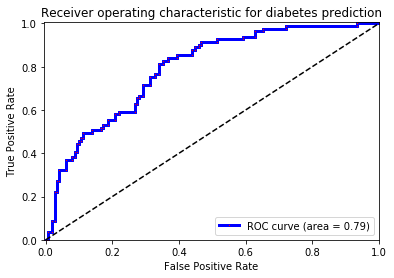

In [72]:
# Plotting the ROC curve
## The ROC curve illustrates the model's diagnostic ability to predict in a binary system, in this case, diabetic or not diabetic.

plt.figure()


plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, lw=3, color ="#0000ff", marker='s',markerfacecolor="red", markersize=2) 
#### plots the ROC curve values based on the false positive and true positve rate that were calculated from the train/test set

plt.plot([0, 1], [0, 1], 'k--') # also plot black dashed line (k=black) from (0,0) to (1,1)
#### labels the "coin flip" curve/outcome, which is the worst possible outcome, onto the figure



# Set x and y ranges, labels, title and legend
plt.xlim([-0.005, 1.0])  #x range basically from 0 to 1: start range a bit to left of min x value to see thick line better
plt.ylim([0.0, 1.005])   #0 range basically from 0 to 1: extend range a bit above max y value to see thick line better
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for diabetes prediction')
plt.legend(loc="lower right")
plt.show()

In [73]:
### Parameter tuning 
C_range = 10.0 ** np.arange(-2, 4)
#gamma_range = 10.0 ** np.arange(-3, 3)
## 'auto' is 1/(# of predictor variables) 
gamma_range = [.01, .1, 1, 'auto', 10, 100]
print(gamma_range)
param_grid = dict(gamma=gamma_range, C=C_range)
param_grid

[0.01, 0.1, 1, 'auto', 10, 100]


{'gamma': [0.01, 0.1, 1, 'auto', 10, 100],
 'C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])}

In [74]:
#### Doing a cross-validation gridsearch to optimize the classifier after creating the initial model.
### Here find the optimal C and gamma to use 

# Gamma parameter defines how far the influence of a single training example reaches
## low values are "far" reaching and high values are "close". 

# The C parameter trades off correct classification of training examples against maximization of the decision.
# Large C values accept a smaller margin if the decision function is better at classifying all training points correctly. 
# Small C encourages a larger margin, and thus a simpler decision function, at the cost of training accuracy. 

# Default is 3-fold cross validation
grid = GridSearchCV(SVC(kernel='linear',cache_size=1000, probability=True), param_grid=param_grid, cv = 3) 

grid.fit(X_train_minmax, y_train)# runs the grid search on the training data only
best_C = grid.best_estimator_.C
best_gamma = grid.best_estimator_.gamma
print("The best C and gamma for linear is: %.5f, %.5f " % (best_C, best_gamma))
grid.best_estimator_

The best C and gamma for linear is: 1.00000, 0.01000 


SVC(C=1.0, cache_size=1000, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [75]:
best_predict_minmax = grid.best_estimator_.predict(X_test_minmax)
pTot = accuracy_score(y_test, best_predict_minmax)
print("Prediction accuracy: ",pTot)
cm = confusion_matrix(y_test, best_predict_minmax)
print(cm) #confusion matrix
report = classification_report(y_test, best_predict_minmax)
print(report) #for each class prints: precision  recall  f1-score   support
# precision(PPV,# of true diabetics over all predicted as diabetic)
# recall(sensitivity, # of corrrectly identified diabetics over all diabetics)  
# f1-score: balance between the precision and the recall 
# support: number of true instances for each label:

## Here we can see that using the best C and gamma estimators, we determine a prediction accuracy of ~0.758

Prediction accuracy:  0.7489177489177489
[[134  16]
 [ 42  39]]
              precision    recall  f1-score   support

           0       0.76      0.89      0.82       150
           1       0.71      0.48      0.57        81

   micro avg       0.75      0.75      0.75       231
   macro avg       0.74      0.69      0.70       231
weighted avg       0.74      0.75      0.73       231



In [76]:
test_svc = SVC(C=100, gamma="auto" ,kernel='poly', degree = 2, cache_size=1000, probability=False) 
clf_test = test_svc.fit(X_train_minmax, y_train) # trains the classifier on the training set
y_pred_minmax_test = test_svc.predict(X_test_minmax) # tests the classifier on the test set
pTot = accuracy_score(y_test, y_pred_minmax_test)
print("Prediction accuracy: ",pTot)

Prediction accuracy:  0.7445887445887446


In [77]:
cm = confusion_matrix(y_test, y_pred_minmax_test)
# TN FP
# FN TP
print(cm)
report = classification_report(y_test, y_pred_minmax_test)
print(report) #for each class prints: precision  recall  f1-score   support

[[136  14]
 [ 45  36]]
              precision    recall  f1-score   support

           0       0.75      0.91      0.82       150
           1       0.72      0.44      0.55        81

   micro avg       0.74      0.74      0.74       231
   macro avg       0.74      0.68      0.69       231
weighted avg       0.74      0.74      0.73       231



In [78]:
probas_ = svc.fit(X_train_minmax, y_train).predict_proba(X_test_minmax)
fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])  # use the probs of (smoke), not of nonsmoking
roc_auc = auc(fpr, tpr)
print("AUC using predict_proba", roc_auc)
#probas_

AUC using predict_proba 0.7920576131687243


# Summary: 
In comparing the linear and rbf kernels, both seem to have similar predictive power, with an AUC of approximately 0.8. 
The degree in both circumstances of rbf and linear is ignored. Degree is only relevant to polynomial kernels. The polynomial kernel performs more poorly than the linear and rbf kernels, possibly due to overfitting of the training data. The underlying distribution might be undersampled. I use the gridsearch to find the best C and gamma parameters for regularization. 

The gamma parameter defines how far the influence of a single training example can reach. So gamma determines the shape of the peaks that are transformed to a higher dimension. A small gamma will change the shape of the transformed peaks with a small, pointed bump in the higher dimensions, and a large gamma gives a softer, broader bump. Thus, a small gamma will give a low bias and high variance but a large gamma will give high bias and low variance.
If separation is not well enough for the model to distinguish between points, then increasing gamma may give  abetter fit, but runs the risk of overfitting.

 C is the parameter for the soft margin cost function. Parameter C will thus trade error penalty for a better fit. In other words, it allows some examples to be placed on the wrong side of the margin in return for a better fit (trades correct classification of training examples against maximization of the decision)
Large C values accept a smaller margin if the decision function is better at classifying all training points correctly. 
Small C encourages a larger margin, and thus a simpler decision function, at the cost of training accuracy. 
So if a model fit is poor because it is trying to separate as many non-diabetic vs diabetic predictions as possible, then I would use a small parameter C to obtain a better fit (and prevent overfitting of the model).